<a href="https://colab.research.google.com/github/alejandrodgb/fastai/blob/main/clean/05_pet_breeds_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [15]:
# For colab development
! [ -e /content ] && pip install -Uqq fastbook
! pip install nbdev
import fastbook
fastbook.setup_book()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from fastbook import *
from fastai.vision.all import *

# From dogs and cats to pet breeds

In [17]:
# Retrieve data from kaggle's pet breed competition
path = untar_data(URLs.PETS)

In [18]:
# Reviewing the data
path.ls()

(#2) [Path('annotations'),Path('images')]

In [19]:
# Update the base path to be the pet competition folder path
Path.BASE_PATH = path

In [20]:
# Review data
path.ls()

(#2) [Path('annotations'),Path('images')]

The annotations folder include information on where the images were taken. This will be ignored as we will be working with a classification problem.

In [21]:
# Exploring images folder
(path/'images').ls()

(#7393) [Path('images/newfoundland_90.jpg'),Path('images/havanese_84.jpg'),Path('images/beagle_192.jpg'),Path('images/beagle_68.jpg'),Path('images/chihuahua_54.jpg'),Path('images/Abyssinian_202.jpg'),Path('images/Bengal_139.jpg'),Path('images/havanese_16.jpg'),Path('images/staffordshire_bull_terrier_177.jpg'),Path('images/saint_bernard_23.jpg')...]

In [22]:
# Extracting the category from the image name using regex
fname = (path/'images').ls()[0]
re.findall(r'(.+)_\d+.jpg$',fname.name)

['newfoundland']

The regex expression looks for strings that:
- `(.+)` include a group of one or more alphanumeric characters
- `_\d+.jpg$` followed by an underscore (`_`), one or more digits (`\d+`), a full stop and the string 'jpg' (`.jgp`), and the end of the string (`$`).

We will label the dataset using a `DataBlock` object. The `DataBlock` object needs:
- The types of data we are working with
- How to get the list of items
- How to label the items
- How to create a validation set

In [23]:
# Label the dataset using a DataBlock object
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224,min_scale=0.75)
)
dls = pets.dataloaders(path/'images')

`DataLoader` structure:

- `blocks=(ImageBlock,CategoryBlock)`: types for the independent and dependent variables
- `get_items=get_image_files`: get the list of files based on a path
- `splitter=RandomSplitter(seed=42)`: randomly split tranin and validation sets
- `get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name')`: get labels applying regex on the name attribute
- `item_tfms=Resize(460)`: resize each image to 460 pixels. This operation performed in the CPU. On the training set, the crop area is chosen randomly while on the validation set the crop area is centered.
- `batch_tfms=aug_transforms(size=224,min_scale=0.75)`: apply transformations to all images in batch with the GPU. This will apply all transformation in testing sets but only resizing in validation sets. When using the `min_scale` parameter of `aug_transforms`, `RandomResizedCrop` is automatically applied.

## Presizing

In [24]:
# Presizing example

# Create a data block
dblock1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_y=parent_label,
                    item_tfms=Resize(460))

In [25]:
(path/'images').ls()[0]

Path('images/newfoundland_90.jpg')

In [26]:
# Create a data loader
dls1 = dblock1.dataloaders([(path/'images').ls()[0]]*100,bs=80)
dls1.train.get_idxs = lambda: Inf.ones

The FastAI presizing pipeline creates better images. Image 1 is the original, Image 2 is the traditionally augmented image, while Image 3 is the FastAI-augmented image. The image is clearer and has less distortion.

This is achieved by increasing the size of the image for each image, then apply the transformation on all images through the GPU.

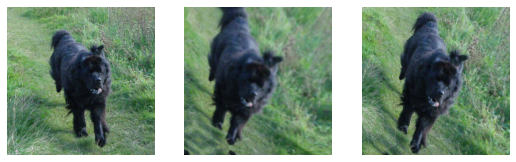

In [27]:
# Extract one batch from data loader
x,y = dls1.valid.one_batch()

# Create canvas for plots
_,axs = subplots(1, 3)

# Create an image with traditional augmentations
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Create a FastAI transforms pipeline
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., 
                                                            size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])

# Apply the FastAI transforms pipeline
x2 = TensorImage(x.clone())
x2 = Pipeline(tfms)(x)

# Show images in plot canvas
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1])
TensorImage(x2[0]).show(ctx=axs[2]);

## Checking and debugging a DataBlock

The `show_batch` method allows us to review the batch images and the classes

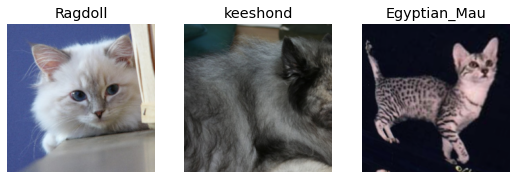

In [28]:
dls.show_batch(nrows=1, ncols=3)

The `summary` method allows us to debug the `DataBlock`. The code below fails because there is no resizing of the images so they cannot be added into a tensor.

In [29]:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'))
pets1.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_73.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_73.jpg
    applying partial gives
      american_pit_bull_terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(13)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(13))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort':

RuntimeError: ignored

Once the `DataBlock` is ready. It is recommendable to create a simple model and test the results.

In [30]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.504010,0.396273,0.130582,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.500895,0.337733,0.104195,01:15
1,0.305930,0.255727,0.079161,01:15


# Cross-Entropy Loss

Cross-Entropy loss is a loss function used for categorical data. To understand how it works, we will dive into the activations and data that the function sees

## Viewing Activations and Labels

In [31]:
# Extract one batch 
x, y = dls.one_batch()

In [32]:
# Dependent variable
y.shape, y

(torch.Size([64]),
 TensorCategory([ 2, 33, 16, 33, 19,  7, 19, 22, 10, 29, 28, 13, 22, 33,  9, 25, 31, 16,  3, 24, 24, 21, 22,  1,  5, 18,  7,  9, 18, 25,  2, 14, 21,  7, 12, 19, 23, 12, 27,  9,  5,  3, 27, 12,  6,  8,
                 12, 30, 11,  9, 21, 10,  0, 30, 19, 11, 25,  3, 18, 26, 19,  9, 13, 10], device='cuda:0'))

In [33]:
# Get predictions
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([3.6975e-07, 1.1199e-06, 9.6190e-01, 2.4264e-05, 8.3120e-07, 1.0724e-07, 1.2117e-05, 2.5113e-04, 3.7523e-02, 1.9950e-08, 2.3138e-04, 2.2481e-07, 1.6224e-07, 1.1397e-08, 1.1097e-07,
            1.5198e-07, 1.9404e-07, 9.5194e-08, 7.6834e-08, 2.3419e-06, 4.7137e-07, 5.0404e-06, 4.7473e-07, 1.8160e-05, 1.1181e-06, 1.8540e-05, 8.4689e-09, 3.9565e-07, 1.7482e-06, 5.1636e-07,
            1.6100e-06, 3.5216e-06, 1.1362e-07, 1.4350e-06, 4.9996e-08, 1.8881e-07, 1.5228e-06])

In [34]:
preds.shape, preds[0].sum()

(torch.Size([64, 37]), TensorBase(1.))

The `get_preds` function allows us to see the predictions based on a dataset index (0 for train and 1 for valid) or an iterator of batches.

This returns 64 lines of 37 predictions. Each corresponding to a dog breed and adding up to 1.

## Softmax

Classifications are passed through a _softmax_ activation function to make sure they range from 0 to 1. It is similar to a _simoid_ function.

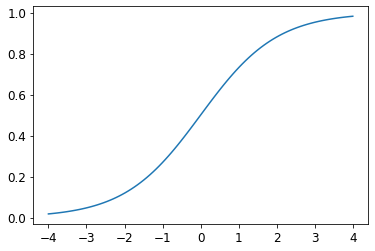

In [35]:
plot_function(torch.sigmoid, min=-4,max=4)

We need to pass our activations for each category through the softmax function to ensure they add up to 1

In [36]:
# Activations example
# Create a random tensor with two categories
torch.random.manual_seed(42)
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

If we take the sigmoid directly, the probabilities of the two categories for each predictino will not add up to 1.

In [37]:
acts.sigmoid(), acts.sigmoid().sum(dim=0),acts.sigmoid().sum(dim=1),acts.sigmoid().sum()

(tensor([[0.6623, 0.5641],
         [0.6151, 0.6132],
         [0.0957, 0.4079],
         [0.9881, 0.2182],
         [0.7157, 0.6306],
         [0.7446, 0.8346]]),
 tensor([3.8215, 3.2686]),
 tensor([1.2263, 1.2283, 0.5036, 1.2063, 1.3463, 1.5792]),
 tensor(7.0900))

In the case of binary classification, we can apply the _sigmoid_ function to the difference between the results. 

This would indicate how sure we are that it is the first item as compared to the second item.

In [38]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

This can be applied to more than two columns through the use of the _softmax_ function.

In [39]:
def softmax(x): return exp(x)/exp(x).sum(dim=1, keepdim=True)

When applied to the set of predictions (row-wise) it will produce the same results as the _sigmoid_ function.

In [40]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

_Softmax_ is the multi-category equivalent of _sigmoid_

## Log Likelihood

In [41]:
# Create targets for acts example
targ = tensor([0,1,0,1,1,0])

In [42]:
# Activations
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [43]:
# Select the correct column for each item
idx = range(6) # Create an index to select the row
sm_acts[idx,targ]


tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

The table below shows all columns in the same table

In [62]:
df = pd.DataFrame({'cat1':sm_acts[:,0],
              'cat2':sm_acts[:,1],
              'idx':idx,
              'targ':targ,
              'result':sm_acts[idx,targ]})
df

,cat1,cat2,idx,targ,result
0,0.602469,0.397531,0,0,0.602469
1,0.502065,0.497935,1,1,0.497935
2,0.133188,0.866811,2,0,0.133188
3,0.996640,0.003360,3,1,0.003360
4,0.595949,0.404051,4,1,0.404051
5,0.366118,0.633882,5,0,0.366118


This can be used with $n$ number of categories.

In [45]:
torch.random.manual_seed(42)
acts2 = torch.randn((6,10))*2
sm_acts2 = torch.softmax(acts2,dim=1)
targ2 = tensor([8,1,4,3,5,3])

In [46]:
cats={f'cat{i+1}':sm_acts2[:,i] for i in range(10)}
cats['targ'] = targ2
cats['idx'] = idx
cats['loss'] = sm_acts2[idx,targ2]

pd.DataFrame(cats)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,targ,idx,loss
0,0.449186,0.186452,0.057688,0.000141,0.036982,0.000806,0.008736,0.000385,0.002116,0.257508,8,0,0.002116
1,0.012639,0.001673,0.006462,0.009051,0.005954,0.127309,0.739784,0.020136,0.010246,0.066747,1,1,0.001673
2,0.002481,0.097686,0.056077,0.325825,0.145965,0.151104,0.038323,0.163138,0.007113,0.012288,4,2,0.145965
3,0.014239,0.131477,0.001477,0.004123,0.015065,0.730577,0.044562,0.010075,0.043404,0.005002,3,3,0.004123
4,0.000866,0.142888,0.003358,0.005862,0.040662,0.027705,0.311409,0.007997,0.351094,0.108160,5,4,0.027705
5,0.778300,0.026240,0.096708,0.028313,0.003726,0.001969,0.006531,0.026273,0.010321,0.021619,3,5,0.028313


We now have a way `sm_acts[idx,targs]` to calculate the loss as long as the the columns add up to one (which they will after the _softmax_ function).

By using _softmax_ we are automatically decreasing the activation number for any other column that we have not predicted. This allows us to ignore the any other column than that that was predicted when calculating the loss.

This can also be achieved with the _negative loss likelihood_ function available in PyTorch: `nll_loss`

In [47]:
-sm_acts[idx,targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [48]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

## Taking the log

We have to take the _log_ of _softmax_ as `nll_loss` expects the input to be the -log_ already. 

`nll_loss` takes the mean of the positive or negative loss of our probabilities. 

We don't use the _softmax_ function directly as it is limited to results from 0 to 1, making a difference like 0.99 and 0.999 similar for our model while in reality it is 10 times larger.

The combination of softmax and then log likelihood is the cross-entropy loss. In PyTorch this is available as `nn.CrossEntropyLoss` which does `log_softmax` and then `nll_loss`. 

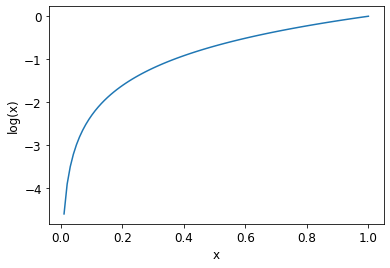

In [56]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

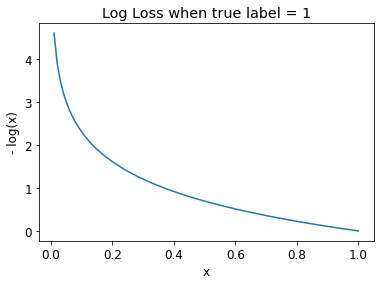

In [57]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [51]:
# Class form of CrossEntropyLoss
loss_func = nn.CrossEntropyLoss()

In [52]:
loss_func(acts, targ)

tensor(1.8045)

In [53]:
# Function form of CrossEntropyLoss
F.cross_entropy(acts, targ)

tensor(1.8045)

Python loss functions take the mean loss of all items. To disable this we can pass `'none'` to the `reduction` parameter.

In [55]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [63]:
df['loss'] = -torch.log(tensor(df['result']))
df

,cat1,cat2,idx,targ,result,loss
0,0.602469,0.397531,0,0,0.602469,0.506720
1,0.502065,0.497935,1,1,0.497935,0.697285
2,0.133188,0.866811,2,0,0.133188,2.015990
3,0.996640,0.003360,3,1,0.003360,5.695763
4,0.595949,0.404051,4,1,0.404051,0.906213
5,0.366118,0.633882,5,0,0.366118,1.004798


# Model Interpretation